Cribbed from PyTissueOptics CuPy version.

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import cupy as cp
import matplotlib.pyplot as plt
import numpy as np
from cupyx import jit
from typing import Tuple

print(f"CuPy version {cp.__version__}")

CuPy version 13.2.0


In [2]:
mempool = cp.get_default_memory_pool()
mempool.free_all_blocks()
print(f"mempool.used_bytes {mempool.used_bytes()}")

mempool.used_bytes 0


In [3]:
@jit.rawkernel(device=True)
def _hanley(g: np.float32, r: np.float32) -> np.float32:
    """r: random[0,2g)"""
    temp = (1 - g * g) / (1 - g + r)
    cost = (1 + g * g - temp * temp) / (2 * g)
    return cp.arccos(cost)

@jit.rawkernel()
def _hanley_loop(random_inout: cp.ndarray, g: np.float32, size: np.int32) -> None:
    tid = jit.blockIdx.x * jit.blockDim.x + jit.threadIdx.x
    ntid = jit.gridDim.x * jit.blockDim.x
    for i in range(tid, size, ntid):
        random_inout[i] = _hanley(g, random_inout[i])

def get_scattering_theta(g: np.float32, size: np.int32) -> cp.ndarray:
    random_input = cp.random.uniform(0, 2 * g, size, dtype=np.float32)
    _hanley_loop((128,),(1024,),(random_input, g, size))
    return random_input

In [4]:
def get_scattering_phi(size: np.int32) -> cp.ndarray:
    return cp.random.uniform(0, 2 * np.pi, size, dtype=np.float32)

In [5]:
@jit.rawkernel(device=True)
def any_perpendicular(vx: np.float32, vy: np.float32, vz: np.float32) -> Tuple[np.float32, np.float32, np.float32]:
    if vz < vx:
        return (vy, -vx, 0.0)
    return (0.0, -vz, vy)

@jit.rawkernel(device=True)
def normalize(x: np.float32, y: np.float32, z: np.float32) -> Tuple[np.float32, np.float32, np.float32]:
    n = cp.sqrt(x * x + y * y + z * z)
    return (x/n, y/n, z/n)

@jit.rawkernel(device=True)
def unitary_perpendicular(vx: np.float32, vy: np.float32, vz: np.float32) -> Tuple[np.float32, np.float32, np.float32]:
    (ux, uy, uz) = any_perpendicular(vx, vy, vz)
    return normalize(ux, uy, uz)    

@jit.rawkernel(device=True)
def do_rotation(X: np.float32, Y: np.float32, Z: np.float32, 
                ux: np.float32, uy: np.float32, uz: np.float32,
                theta: np.float32) -> Tuple[np.float32, np.float32, np.float32]:
    """ Rotate v around u. """
    cost = cp.cos(theta)
    sint = cp.sin(theta)
    one_cost = 1 - cost
           
    x = (cost + ux * ux * one_cost) * X + (ux * uy * one_cost - uz * sint) * Y + (
            ux * uz * one_cost + uy * sint) * Z
    y = (uy * ux * one_cost + uz * sint) * X + (cost + uy * uy * one_cost) * Y + (
            uy * uz * one_cost - ux * sint) * Z
    z = (uz * ux * one_cost - uy * sint) * X + (uz * uy * one_cost + ux * sint) * Y + (
            cost + uz * uz * one_cost) * Z
    
    return (x, y, z)

@jit.rawkernel()
def scatter(vx: cp.ndarray, vy: cp.ndarray, vz: cp.ndarray,
            theta: cp.ndarray, phi: cp.ndarray, size: np.int32) -> None:
    tid = jit.blockIdx.x * jit.blockDim.x + jit.threadIdx.x
    ntid = jit.gridDim.x * jit.blockDim.x
    for i in range(tid, size, ntid):
        (ux, uy, uz) = unitary_perpendicular(vx[i], vy[i], vz[i])

        # first rotate the perpendicular around the photon axis
        (ux, uy, uz) = do_rotation(ux, uy, uz, vx[i], vy[i], vz[i], phi[i])
            
        # then rotate the photon around that perpendicular
        (vx[i], vy[i], vz[i]) = do_rotation(vx[i], vy[i], vz[i], ux, uy, uz, theta[i])

def get_phi(y: cp.ndarray, x: cp.ndarray) -> cp.ndarray:
    return cp.arctan2(y, x)

def get_theta(z: cp.ndarray) -> cp.ndarray:
    return cp.arccos(z)

In [13]:
g = np.float32(0.95)
# size = np.int32(20000000)
size = np.int32(200000)

In [14]:
r_x = cp.random.random(size, dtype=np.float32)
r_y = cp.random.random(size, dtype=np.float32)
r_z = cp.random.random(size, dtype=np.float32)
# isotropic
# ez_x = cp.random.random(size, dtype=np.float32)
# ez_y = cp.random.random(size, dtype=np.float32)
# ez_z = cp.random.random(size, dtype=np.float32)
# like the pencil case
ez_x = cp.zeros(size, dtype=np.float32)
ez_y = cp.zeros(size, dtype=np.float32)
ez_z = cp.full(size, 1.0, dtype=np.float32)

In [15]:
%%time
phi = get_scattering_phi(size)
theta = get_scattering_theta(g, size)
scatter((128,),(1024,),(ez_x, ez_y, ez_z, theta, phi, size))

CPU times: user 1.64 ms, sys: 0 ns, total: 1.64 ms
Wall time: 1.22 ms


<BarContainer object of 50 artists>

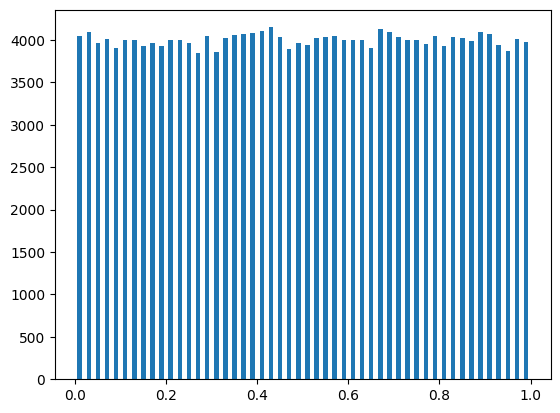

In [16]:
(hist, bin_edges) = cp.histogram(r_x, bins=50, range=(0,1))
plt.bar(x=0.5 * (bin_edges.get()[:-1] + bin_edges.get()[1:]),
        height=hist.get(), width = 0.01)

<BarContainer object of 50 artists>

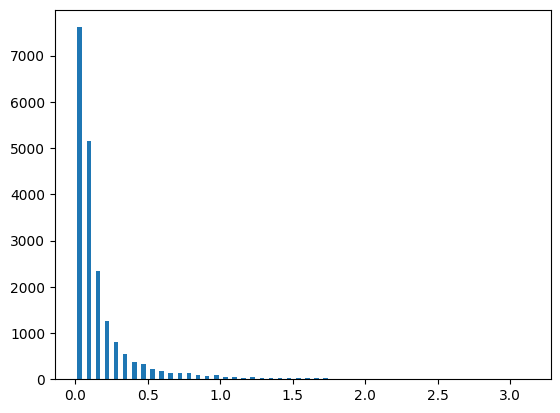

In [12]:
(theta_hist, theta_bins) = cp.histogram(get_theta(ez_z), bins=50, range=(0, np.pi))
plt.bar(x=0.5 * (theta_bins.get()[:-1] + theta_bins.get()[1:]),
        height=theta_hist.get(), width=np.pi/100)